# Statistical tests in R

For most statistical tests, there are already functions implemented in R. The trick is then only to know which test to use.

Some commonly used tests are explained here:

[ http://r-statistics.co/Statistical-Tests-in-R.html ]

A large overview on statistical tests can be found here:

[ http://www.biostathandbook.com/testchoice.html ]

### Example: July SST at station BY31 (Landsort Deep)

Let us read in the ICES dataset we already used for fitting the GAMM.

decimalyear,temperature
1877.566,15.40
1891.680,10.40
1893.505,13.55
1898.284,2.07
1898.713,11.53
1899.418,5.56


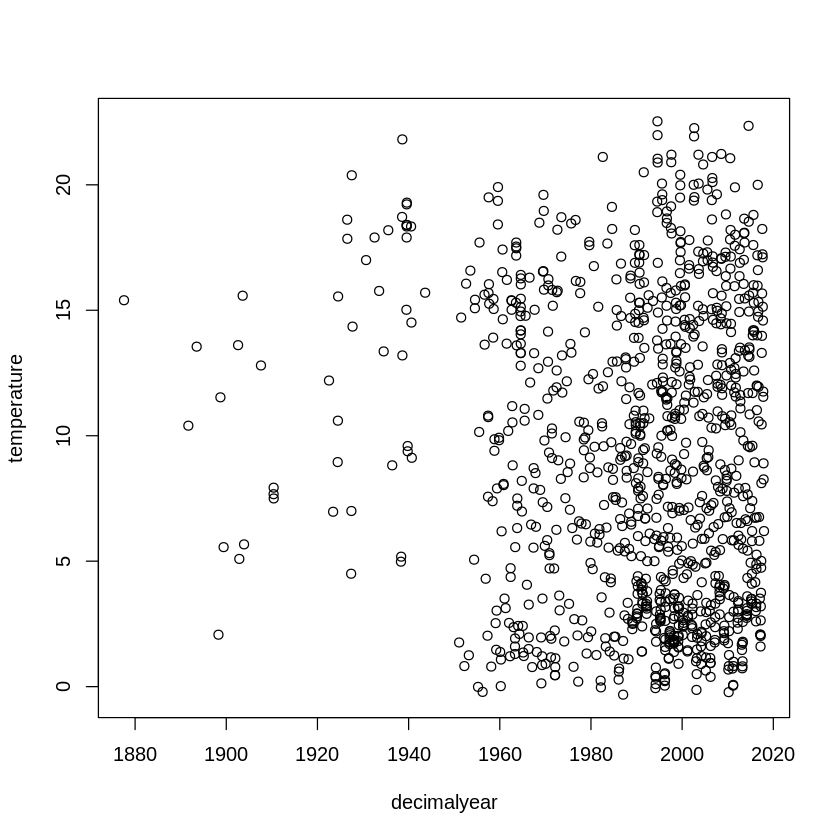

In [1]:
icesdata = read.csv("../Data/sst_by31.csv",sep=";")
head(icesdata)
plot(icesdata)

Again we define a season:

In [2]:
# get the year
icesdata$year = floor(icesdata$decimalyear)
# subtract it from decimalyear to get the season
icesdata$season = icesdata$decimalyear - icesdata$year

head(icesdata)

decimalyear,temperature,year,season
1877.566,15.40,1877,0.5655738
1891.680,10.40,1891,0.6803279
1893.505,13.55,1893,0.5054645
1898.284,2.07,1898,0.2841530
1898.713,11.53,1898,0.7131148
1899.418,5.56,1899,0.4180328


For simplicity we assume that "July" means $6/12 < season < 7/12$. Let's extract all July values then.

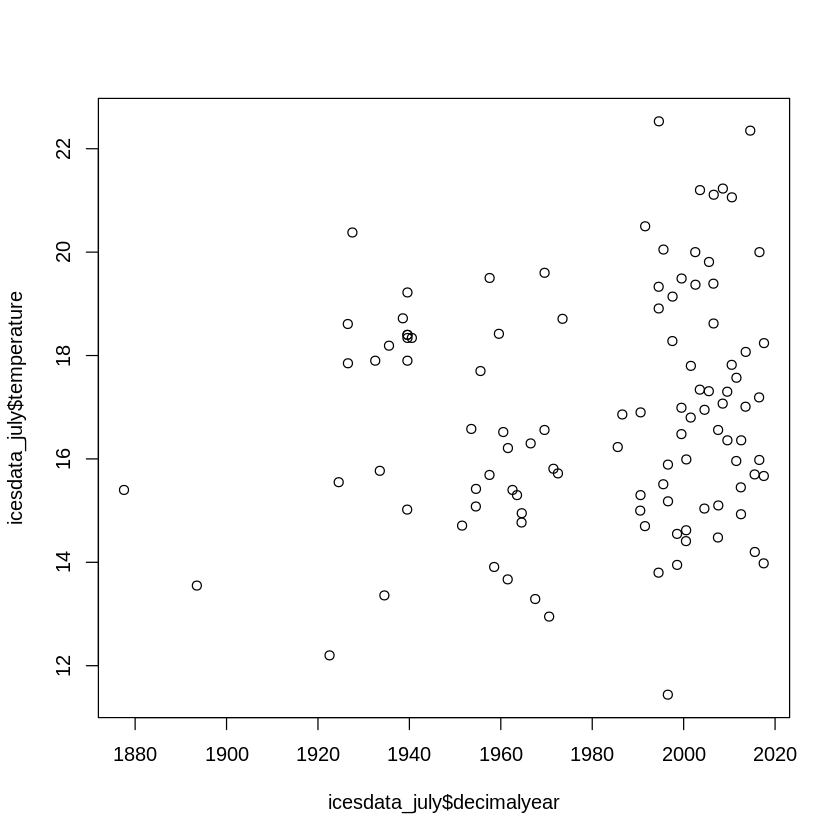

In [3]:
icesdata_july = icesdata[(icesdata$season > 6/12) & (icesdata$season < 7/12),]
plot(icesdata_july$decimalyear, icesdata_july$temperature)

For some July's, there seem to be several measurements. Let us calculate averages from them.

In [4]:
july_means = aggregate(icesdata_july$temperature,by = list(year=icesdata_july$year),FUN=mean)
head(july_means)

year,x
1877,15.40
1893,13.55
1922,12.20
1924,15.55
1926,18.23
1927,20.38


year,temperature
1877,15.40
1893,13.55
1922,12.20
1924,15.55
1926,18.23
1927,20.38


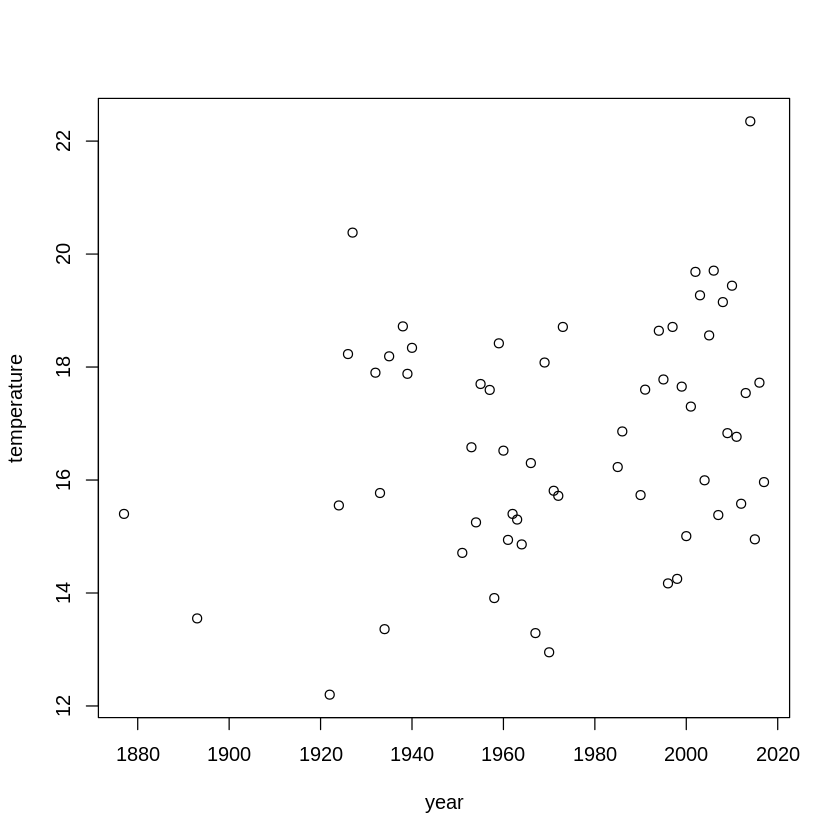

In [5]:
july_means = aggregate(icesdata_july$temperature,by = list(year=icesdata_july$year),FUN=mean)
colnames(july_means)[2]="temperature"
head(july_means)
plot(july_means)

#### Can we say that July mean temperature was different before and after 1980?

In [6]:
period1 = july_means$year < 1980
period2 = july_means$year >= 1980

temperatures1 = july_means$temperature[period1]
temperatures2 = july_means$temperature[period2]

temperatures1
temperatures2

[1] 15.400 13.550 12.200 15.550 18.230 20.380 17.900 15.770 13.360 18.190
[11] 18.720 17.880 18.340 14.710 16.580 15.250 17.700 17.595 13.910 18.420
[21] 16.520 14.940 15.400 15.300 14.860 16.300 13.290 18.080 12.950 15.810
[31] 15.720 18.710

[1] 16.23000 16.86000 15.73333 17.60000 18.64250 17.78000 14.17000 18.71000
 [9] 14.25000 17.65333 15.00667 17.30000 19.68500 19.27000 15.99500 18.56000
[17] 19.70667 15.38000 19.15000 16.83000 19.44000 16.76500 15.58000 17.54000
[25] 22.35000 14.95000 17.72333 15.96333

Let's first check for autocorrelation.

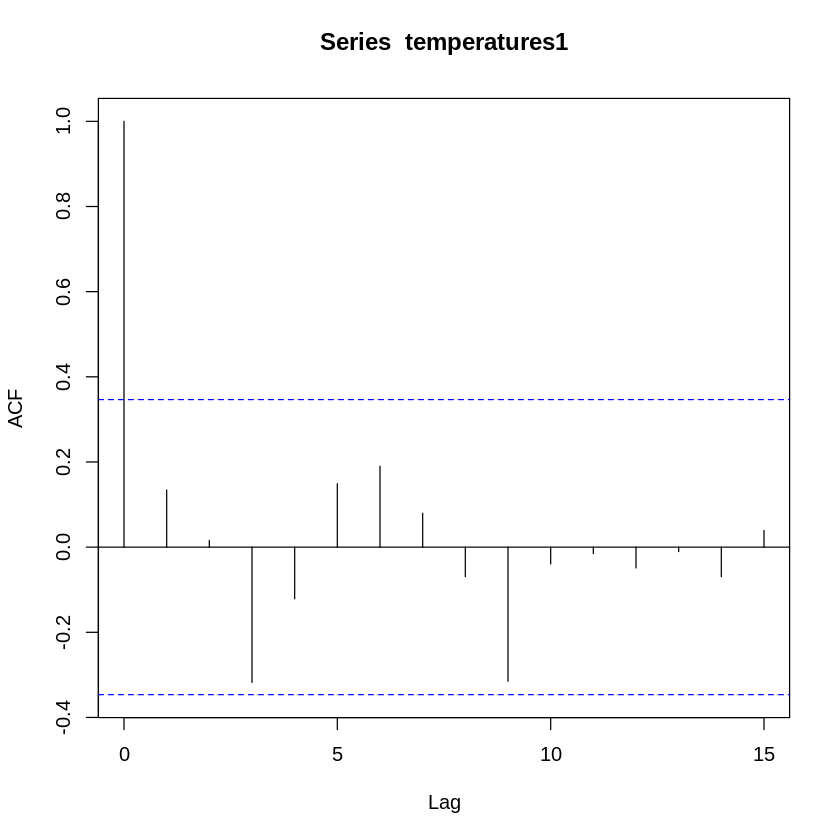

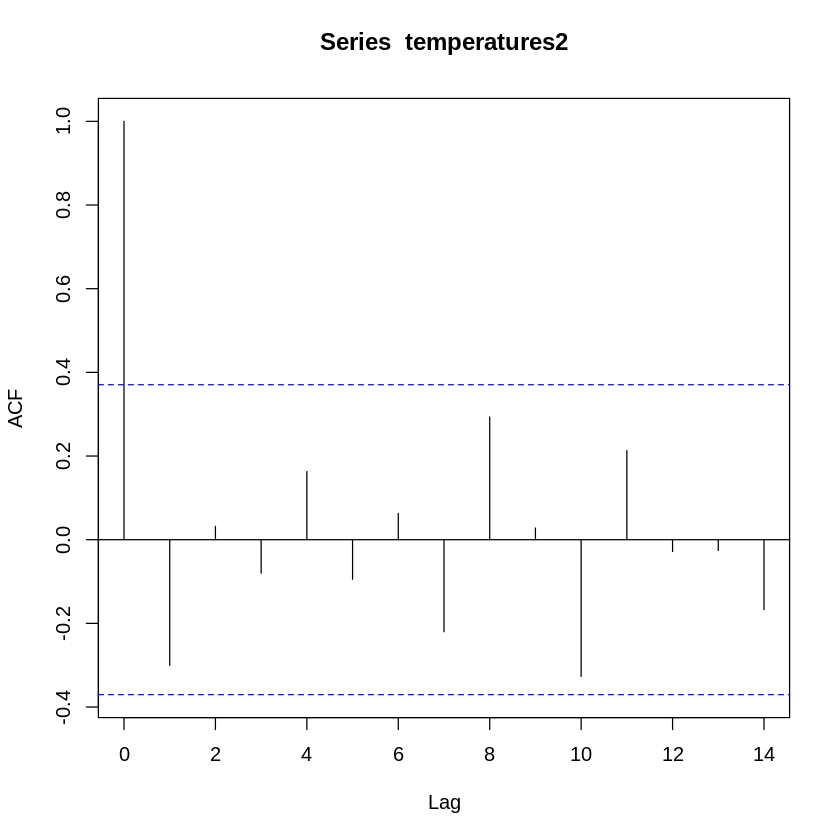

In [7]:
acf(temperatures1)
acf(temperatures2)

Well, that's fine. No significant autocorrelation.

So we look at the first table to find out which test we need.

[ http://r-statistics.co/Statistical-Tests-in-R.html ]

In [9]:
?t.test

In [10]:
t.test(x=temperatures1, y=temperatures2, alternative = "less")


	Welch Two Sample t-test

data:  temperatures1 and temperatures2
t = -2.2472, df = 57.591, p-value = 0.01424
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
       -Inf -0.2926473
sample estimates:
mean of x mean of y 
 16.17234  17.31515 


But is the test valid? Are the values normally distributed? We find out that a Shapiro test may tell us.

In [ ]:
?shapiro.test

In [11]:
shapiro.test(temperatures1)
shapiro.test(temperatures2)


	Shapiro-Wilk normality test

data:  temperatures1
W = 0.96624, p-value = 0.4027



	Shapiro-Wilk normality test

data:  temperatures2
W = 0.96988, p-value = 0.5775


Well, the data passed this test. But this does not guarantee they are actually normally distributed. So let's go for the more general test as well.

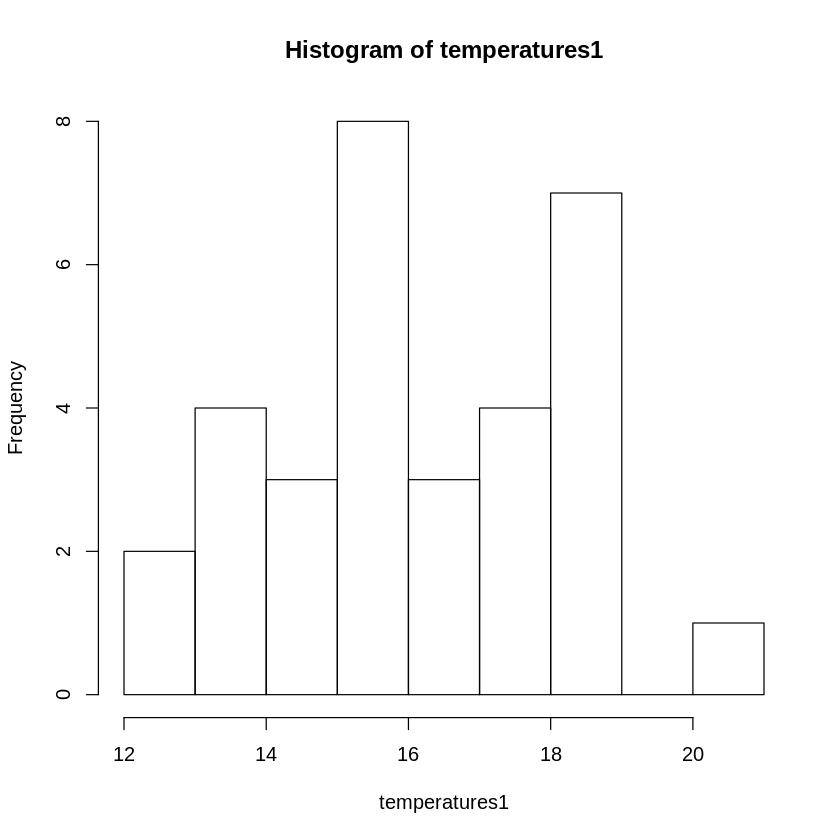

In [13]:
hist(temperatures1)

In [12]:
wilcox.test(x=temperatures1, y=temperatures2, alternative = "less")

Warning message in wilcox.test.default(x = temperatures1, y = temperatures2, alternative = "less"):
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  temperatures1 and temperatures2
W = 314.5, p-value = 0.02438
alternative hypothesis: true location shift is less than 0


This didn't work out. We have to make the values unique by adding some noise.

In [14]:
runif(10)

[1] 0.8228381 0.2979287 0.5583494 0.8467793 0.3071478 0.9668345 0.3358254
 [8] 0.1792454 0.8428244 0.2947422

In [18]:
noise1 = 1e-10*runif(length(temperatures1))
noise2 = 1e-10*runif(length(temperatures2))

wilcox.test(x=temperatures1+noise1, y=temperatures2+noise2, alternative = "less")


	Wilcoxon rank sum test

data:  temperatures1 + noise1 and temperatures2 + noise2
W = 315, p-value = 0.02455
alternative hypothesis: true location shift is less than 0


Yes, both tests told us that July temperatures were significantly higher after 1980 than before.

#### Can we find out whether July temperature variability has changed after 1980?

We look at the advanced table:

[ http://www.biostathandbook.com/testchoice.html ]

and find out that it is the Bartlett's test we need.

In [19]:
?bartlett.test

In [20]:
bartlett.test(list(temperatures1, temperatures2))


	Bartlett test of homogeneity of variances

data:  list(temperatures1, temperatures2)
Bartlett's K-squared = 0.075467, df = 1, p-value = 0.7835


In [21]:
sd(temperatures1)
sd(temperatures2)

[1] 2.018747

[1] 1.917128

In [22]:
?fisher.test

In [23]:
fisher.test(temperatures1,temperatures2)

ERROR: Error in fisher.test(temperatures1, temperatures2): 'x' and 'y' must have the same length


So we see no significant change in variance between the two periods before and after 1980.